# 0. Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

# 1. Build Data Loading Functions

In [2]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [5]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [6]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [7]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [8]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [9]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [10]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [11]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [12]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

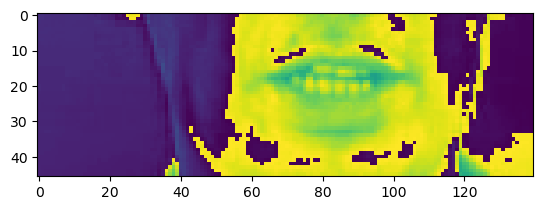

In [13]:
plt.imshow(frames[40])

In [14]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [15]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [16]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [17]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [18]:
len(test)

50

In [19]:
frames, alignments = data.as_numpy_iterator().next()

In [20]:
len(frames)

2

In [21]:
sample = data.as_numpy_iterator()

In [22]:
val = sample.next(); val[0]

array([[[[[ 1.4347916 ],
          [ 1.4347916 ],
          [ 1.4347916 ],
          ...,
          [10.760937  ],
          [10.718738  ],
          [10.718738  ]],

         [[ 1.4347916 ],
          [ 1.4347916 ],
          [ 1.4347916 ],
          ...,
          [10.760937  ],
          [10.718738  ],
          [10.718738  ]],

         [[ 1.3925918 ],
          [ 1.3925918 ],
          [ 1.3925918 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.97059435],
          [ 0.97059435],
          [ 0.97059435],
          ...,
          [10.465539  ],
          [10.465539  ],
          [10.465539  ]],

         [[ 0.92839456],
          [ 0.92839456],
          [ 0.92839456],
          ...,
          [10.465539  ],
          [10.465539  ],
          [10.465539  ]],

         [[ 0.92839456],
          [ 0.92839456],
          [ 0.92839456],
          ...,
          [10.465539  ],
          [10.465539  ],
          

In [23]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.760936737060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

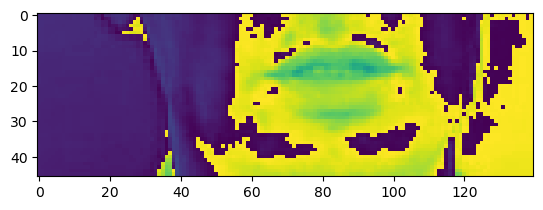

In [24]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][10])

In [25]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green by r one soon'>

# 3. Design the Deep Neural Network

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [30]:
5*17*75

6375

In [31]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [32]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbuuuuuuuuuuuuuuuuuuuuuuuuuuuu'>

In [33]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbuuuuuuuuuuuuuuuuuuuuuuuuuuuu'>

In [34]:
model.input_shape

(None, 75, 46, 140, 1)

In [35]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [36]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [37]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [38]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [40]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [41]:
schedule_callback = LearningRateScheduler(scheduler)

In [42]:
example_callback = ProduceExample(test)

In [43]:
#model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [44]:
model.load_weights('.\\models\\checkpoint')

In [45]:
test_data = test.as_numpy_iterator()

In [103]:
#sample = test_data.next()

In [104]:
#yhat = model.predict(sample[0])

1/1 [==============================] - 12s 12s/step


# Test on a Video

In [120]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbwm5s.mpg'))

In [106]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with m five soon'>]

In [107]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 3s 3s/step


In [108]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [109]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with five soon'>]

In [110]:
import ipywidgets as widgets
from IPython.display import display, HTML, Video


In [46]:
def predict_lip_reading(video_path):
    # Load video and process it with your model (replace with your logic)
    sample = load_data(tf.convert_to_tensor(video_path))
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    # Convert prediction to text
    converted_prediction = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    decoded_prediction = tf.strings.reduce_join(converted_prediction).numpy().decode('utf-8')
    return decoded_prediction

In [112]:
predict_lip_reading('.\\uploads\\bbaf2n.mpg')

1/1 [==============================] - 3s 3s/step


'bin blue at f two now'

In [113]:
# Create File Upload widget
file_upload = widgets.FileUpload(
    accept='.mpg',  # Specify accepted file type
    multiple=False,  # Allow only one file to be uploaded
    description='Upload Video'
)

# Create a Button widget
predict_button = widgets.Button(
    description='Predict',
    disabled=True  # Disable button initially
)

# Create an Output widget for displaying predictions
output_widget = widgets.Output(
    description='Output',
)

In [48]:
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf

# Create Tkinter window
root = tk.Tk()
root.title("Visual Speech Recognition")

# Set background color to peach
root.configure(bg='#FFDAB9')  # Peach color

# Set default font style and size
default_font = ('Times New Roman', 14)

# Create File Upload function
def upload_video():
    file_path = filedialog.askopenfilename(filetypes=[("Video Files", "*.mpg")])
    uploaded_label.config(text=f"Uploaded: {file_path}")

# Create Predict function
def predict_lip_reading():
    video_path = uploaded_label.cget("text").replace("Uploaded: ", "")
    # Add your lip reading prediction logic here
    sample = load_data(tf.convert_to_tensor(video_path))
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    converted_prediction = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    decoded_prediction = tf.strings.reduce_join(converted_prediction).numpy().decode('utf-8')
    
    # Display the prediction on the Tkinter window with black text
    prediction_label.config(text=f"Decoded Prediction: {decoded_prediction}", fg='black')

# Create a top heading
heading_label = tk.Label(root, text="Visual Speech Recognition", bg='#FFDAB9', fg='#008CBA', font=('Times New Roman', 24, 'bold'))  # Peach color, blue text, bold font
heading_label.pack(pady=10)

# Create File Upload button
upload_button = tk.Button(root, text="Upload Video", command=upload_video, bg='#FF6347', fg='black', font=default_font)  # Tomato color, black text
upload_button.pack(pady=10)

# Label to display uploaded file path
uploaded_label = tk.Label(root, text="Uploaded: None", bg='#FFDAB9', fg='black', font=default_font)  # Peach color, black text
uploaded_label.pack(pady=10)

# Create Predict button
predict_button = tk.Button(root, text="Predict Lip Reading", command=predict_lip_reading, bg='#008CBA', fg='black', font=default_font)  # Blue color, black text
predict_button.pack(pady=10)

# Label to display the prediction
prediction_label = tk.Label(root, text="Decoded Prediction: ", bg='#FFDAB9', fg='black', font=('Times New Roman', 18, 'bold'))  # Peach color, black text, bold font
prediction_label.pack(pady=10)

# Add top margin of 50 pixels
top_margin = 50
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()
x_position = int((screen_width - root.winfo_reqwidth()) / 2)
y_position = int((screen_height - root.winfo_reqheight()) / 2) - top_margin
root.geometry(f"{root.winfo_reqwidth()}x{root.winfo_reqheight()}+{x_position}+{y_position}")

# Start Tkinter event loop
root.mainloop()


1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

save using pickle


TSET USING LOADED MODEL

In [116]:
#########################################################final frontend#############################################3
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf

# Create Tkinter window
root = tk.Tk()
root.title("Visual Speech Recognition")

# Set background color to peach
root.configure(bg='#FFDAB9')  # Peach color

# Set default font style and size
default_font = ('Times New Roman', 14)

# Create File Upload function
def upload_video():
    file_path = filedialog.askopenfilename(filetypes=[("Video Files", "*.mpg")])
    uploaded_label.config(text=f"Uploaded: {file_path}")

# Create Predict function
def predict_lip_reading():
    video_path = uploaded_label.cget("text").replace("Uploaded: ", "")
    # Add your lip reading prediction logic here
    sample = load_data(tf.convert_to_tensor(video_path))
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    converted_prediction = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    decoded_prediction = tf.strings.reduce_join(converted_prediction).numpy().decode('utf-8')
    
    # Display the prediction on the Tkinter window with white text
    prediction_label.config(text=f"Decoded Prediction: {decoded_prediction}", fg='white')

# Create a top heading
heading_label = tk.Label(root, text="Visual Speech Recognition", bg='#FFDAB9', fg='#008CBA', font=('Times New Roman', 24, 'bold'))  # Peach color, blue text, bold font
heading_label.pack(pady=10)

# Create File Upload button
upload_button = tk.Button(root, text="Upload Video", command=upload_video, bg='#FF6347', fg='white', font=default_font)  # Tomato color, white text
upload_button.pack(pady=10)

# Label to display uploaded file path
uploaded_label = tk.Label(root, text="Uploaded: None", bg='#FFDAB9', fg='white', font=default_font)  # Peach color, white text
uploaded_label.pack(pady=10)

# Create Predict button
predict_button = tk.Button(root, text="Predict Lip Reading", command=predict_lip_reading, bg='#008CBA', fg='white', font=default_font)  # Blue color, white text
predict_button.pack(pady=10)

# Label to display the prediction
prediction_label = tk.Label(root, text="Decoded Prediction: ", bg='#FFDAB9', fg='white', font=('Times New Roman', 18, 'bold'))  # Peach color, white text, bold font
prediction_label.pack(pady=10)

# Add top margin of 50 pixels
top_margin = 50
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()
x_position = int((screen_width - root.winfo_reqwidth()) / 2)
y_position = int((screen_height - root.winfo_reqheight()) / 2) - top_margin
root.geometry(f"{root.winfo_reqwidth()}x{root.winfo_reqheight()}+{x_position}+{y_position}")

# Start Tkinter event loop
root.mainloop()
